# Redundant sensors

In this example, we extend the `Simple gyro` example to a sensor with redundant
sensing axes.  Four (or more) sensors arranged in a non-orthogonal configuration
can provide fault tolerance.  It has been shown that this *tetrad* arrangement
is superior to redundant 3-axis orthogonal systems (six total sensors).  See
[Reference [21]][references] for more details.

## Sensor geometry

We simulate a 4-axis sensor with each sensing axis normal to the face of a
tetrahedron.  The sensing axes are illustrated in red in the image below (the
fourth axis on the rear face is not shown for clarity).  The `x`,`y`,`z` input
reference axes are shown.  It is apparent that one sensing axis is aligned with
the negative `z` input reference axis while the other three axes measure
some component of all the input reference axes.

![Tetrahedron](images/tetrahedron.svg)

## Create and visualize the input

We reuse the input from the `Simple gyro` example.

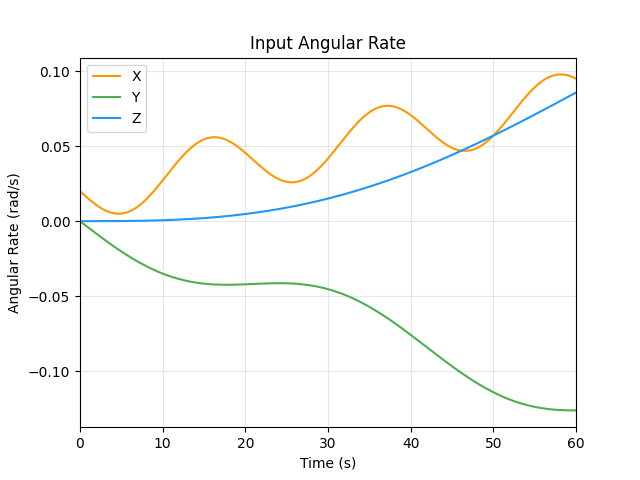

In [1]:
# -----------------------------------------------------------------------------
# Copyright (c) 2023-2025, Inertial Simulation LLC.
# This example is licensed under the CC BY-NC-SA 4.0 license.
# https://creativecommons.org/licenses/by-nc-sa/4.0/
# Email: info@inertialsim.com
# -----------------------------------------------------------------------------
%matplotlib widget

import numpy as np

from inertialsim import plot
from inertialsim.geometry import Vector
from inertialsim.time import span

# Create a time 0:60s time vector sampled at 10Hz
time = span(start=0.0, end=60.0, dt=0.1)

# Create a 3-axis sinusoidal signal with arbitrary frequency and phase.  This is
# applied to the input reference axes (IRA).  See Figure above.
angular_rate = np.zeros((time.size, 3, 1))
angular_rate[:, 0:1] = 0.001 * time - 0.02 * np.sin(0.3 * time) + 0.02
angular_rate[:, 1:2] = -0.002 * time + 0.015 * np.sin(-0.15 * time)
angular_rate[:, 2:3] = 0.0015 * time - 0.03 * np.sin(0.05 * time)

rate_vector = Vector.from_xyz(angular_rate, time)

rate_plot = plot.TimeSeries(title="Input Angular Rate", ylabel="Angular Rate (rad/s)")
rate_plot.line(time, angular_rate, xlimits=[0, 60])
rate_plot.legend(["X", "Y", "Z"])

## Simulate a redundant gyro measuring the input

Next we create and simulate an ideal 4-axis gyro (no noise, bias or other
errors) in order to visualize the redundancy.  The
[GyroSpecification][inertialsim.sensors.gyro.GyroSpecification] has a
[misalignment.fixed][inertialsim.sensors.gyro.GyroSpecification.Misalignment.fixed]
field which maps the input reference axes (typically marked on the case of the
physical device) to the internal sensing axes.

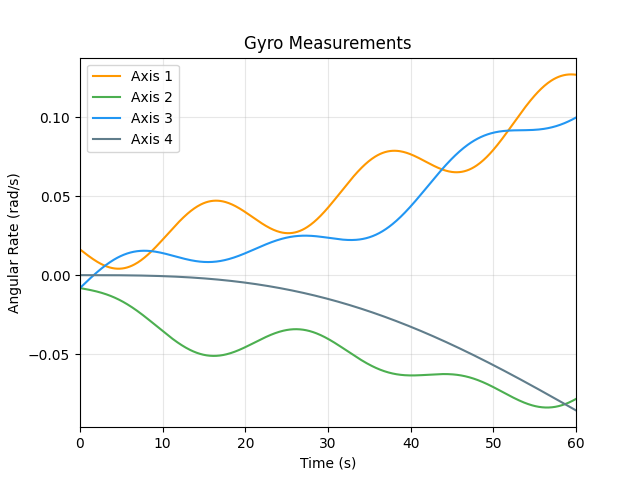

In [4]:
from inertialsim.sensors import Parameter
from inertialsim.sensors.gyro import Gyro, GyroModel, GyroSpecification

# Create a gyro model and keep the input sampling rate (10Hz).
model = GyroModel()
model.data_interface.simulate_sample_rate = False

# Create a default specification and set the input axes
specification = GyroSpecification(axes=4)
# Each row maps the input reference axes (IRA) to the measurement axes.  The
# components are functions of the tetrahedron external angles (120 degrees) and
# dihedral angle (~70.529 degrees).
specification.misalignment.fixed = Parameter(
    [
        [np.sqrt(2 / 3), 0, np.sqrt(1 / 3)],
        [-np.sqrt(1 / 6), np.sqrt(1 / 2), np.sqrt(1 / 3)],
        [-np.sqrt(1 / 6), -np.sqrt(1 / 2), np.sqrt(1 / 3)],
        [0, 0, -1],
    ],
    "dimensionless",
)
gyro = Gyro(model, specification)
output = gyro.simulate(angular_rate=rate_vector)

rate_plot = plot.TimeSeries(title="Gyro Measurements", ylabel="Angular Rate (rad/s)")
rate_plot.line(time, output.angular_rate.data, xlimits=[0, 60])
rate_plot.legend(["Axis 1", "Axis 2", "Axis 3", "Axis 4"])

## Analyzing the result

As expected the fourth sensing axis measures the (negative) `z-axis` input while
the other axes measure components of all the inputs.  The first sensing axis
lies in the `x-z` input plane and does not measure any component of the `y`
input.  This examples demonstrates InertialSim's ability to simulate any
combination of input and sensing geometry.